In [1]:
#https://huggingface.co/blog/fine-tune-vit

pip install datasets transformers

Note: you may need to restart the kernel to use updated packages.


# Load a dataset

In [3]:
from datasets import load_dataset

#We'll use the beans dataset, which is a collection of pictures of healthy and unhealthy bean leaves

ds = load_dataset('beans')
ds

Using custom data configuration default


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to C:\Users\Rozita\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [4]:
#each example from the dataset has 3 features:
#1-image: A PIL Image
#2-image_file_path: The str path to the image file that was loaded as image
#3-labels: A datasets.ClassLabel feature, which is an integer representation of the label.
    
ex = ds['train'][400]
ex

{'image_file_path': 'C:\\Users\\Rozita\\.cache\\huggingface\\datasets\\downloads\\extracted\\5d7a29cae16655e7ae713dfdc137da7296321b4dbfd84d393011471444ecc2e9\\train\\bean_rust\\bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x1C86C56AB80>,
 'labels': 1}

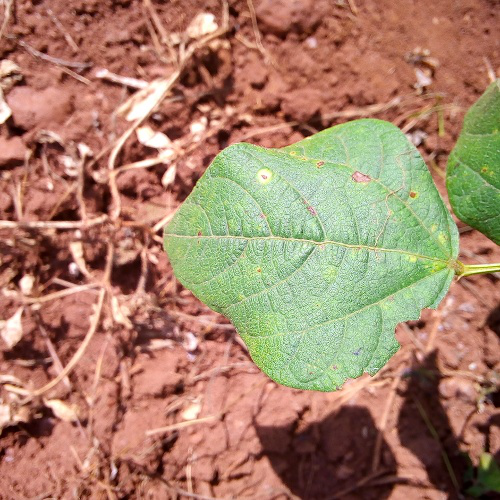

In [5]:
# take a look at image

image = ex['image']
image

# access the feature definition for the 'labels'

In [8]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [9]:
labels.int2str(ex['labels'])

'bean_rust'

Loading cached processed dataset at C:\Users\Rozita\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-e56132f7dc287226.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

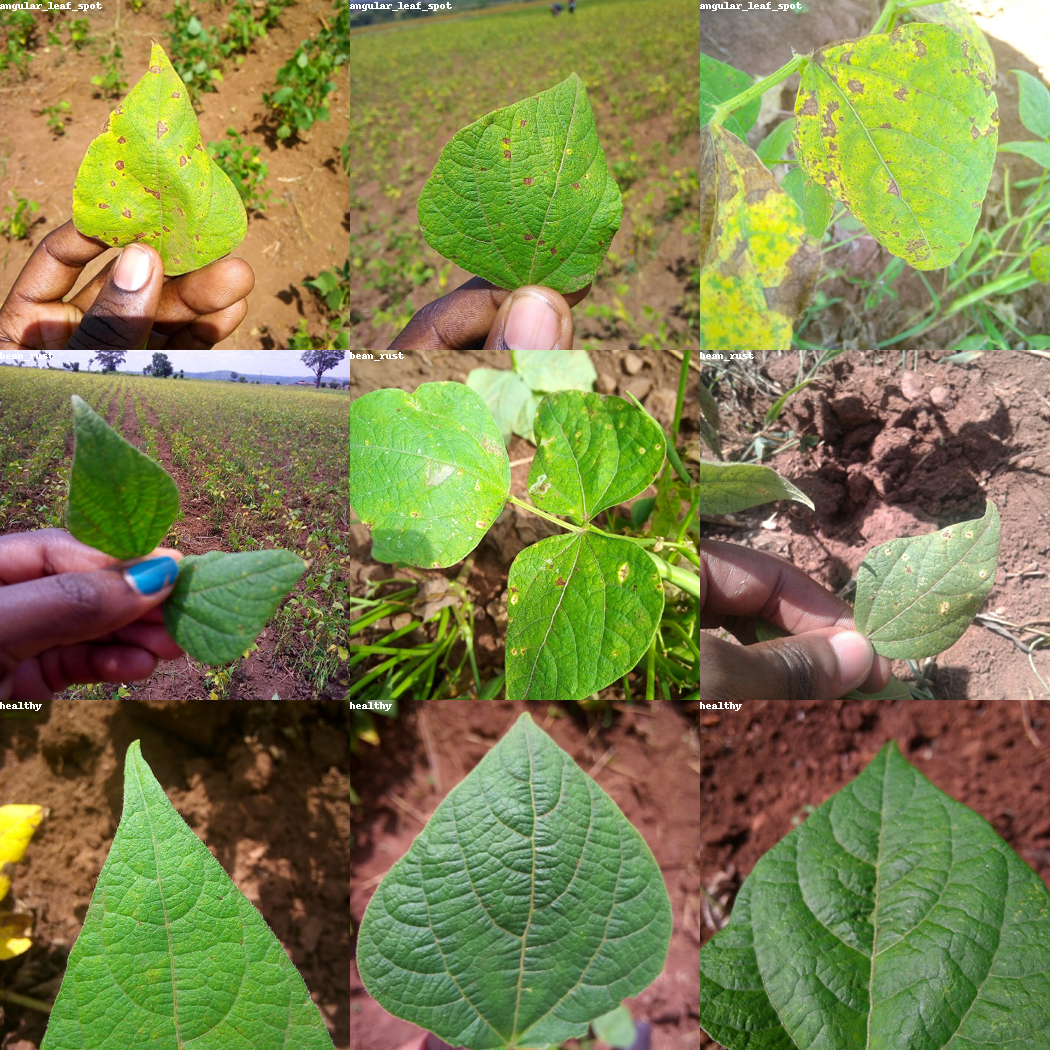

In [12]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
   # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))#, font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

#Angular Leaf Spot: Has irregular brown patches
#Bean Rust: Has circular brown spots surrounded with a white-ish yellow ring
#Healthy: ...looks healthy.

# Loading ViT Feature Extractor

In [15]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [16]:
#To process an image, simply pass it to the feature extractor's call function. This will return 
#a dict containing pixel values, which is the numeric representation to be passed to the model.
#You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.
# shape of the tensor is (1, 3, 224, 224).
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7020,  0.6000,  0.6863,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4824,  0.4039,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8275]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7176, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0510,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9765, -0.9608, -0.9373],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.3020, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4353,  0.2706,  0.3098,  ..., -0.7176, -0.6392, -0.6863],
          [ 0

# Processing the dataset

In [17]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [18]:
# for whole dataset

In [19]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

Using custom data configuration default
Reusing dataset beans (C:\Users\Rozita\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
prepared_ds = ds.with_transform(transform)
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

# Training and Evaluation

Define a collate function.

Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. You should define a compute_metrics function accordingly.

Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.

Define the training configuration.

After fine-tuning the model, you will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify the images.

# Define our data collator

In [22]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# Define an evaluation metric

In [23]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [24]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using amp half precision backend


# Train

In [27]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\Rozita\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss,Accuracy
100,0.079000,0.098821,0.977444
200,0.012500,0.030060,0.992481


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans\checkpoint-100
Configuration saved in ./vit-base-beans\checkpoint-100\config.json
Model weights saved in ./vit-base-beans\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./vit-base-beans\checkpoint-100\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans\checkpoint-200
Configuration saved in ./vit-base-beans\checkpoint-200\config.json
Model weights saved in ./vit-base-beans\checkpoint-200\pytorch_model.bin
Feature extractor saved in ./vit-base-beans\checkpoint-200\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans\checkpoint-200 (score: 0.030059585347771645).
Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans\config.json
Model weights saved in ./vi

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1304
  train_runtime            =  0:04:31.13
  train_samples_per_second =      15.254
  train_steps_per_second   =       0.959


# Evaluate

In [28]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0301
  eval_runtime            = 0:00:04.35
  eval_samples_per_second =     30.519
  eval_steps_per_second   =      3.901


# push the model to the hub

In [29]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)